# Info 6010 Ex 4
### due 17 Apr 2020

Rather than working from this notebook, it's best if you start a new notebook.<br>
The first cell should be a markdown cell containing your name.<br>
Then you should transfer only the cells you need into the new notebook, so they're not lost in the explanatory text below.

Upload to: https://pgcourse.infosci.cornell.edu/cgi-bin/probset.py

Most of this was set up in Lecture 8 on 13 Mar, and was originally intended to be posted on 14 Mar (with some additional explanation intended in Lecture 9 today 20 Mar, which of course was deferred to 10 Apr).

## 1) Presidential Election Simulation I

The [538 forecast 2016](https://projects.fivethirtyeight.com/2016-election-forecast/) has the final aggregated poll data frozen in place from 8 Nov 2016. Based on the state by state poll data, that site made very accurate predictions of electoral vote outcome in both 2008 and 2012, by a methodology described in part in
[538 model](https://fivethirtyeight.com/features/how-the-fivethirtyeight-senate-forecast-model-works/).  The objective here is to get some glimmer of how they determine an overall "chance of winning" percentage. (Unlike the coin flip cases considered so far, there's no convenient exact form, and it's simplest to do a simulation, just as Silver and his group do for each election.)

Scrolling down the above 538 page, we see an expected margin of victory for each state given as a center dot and an 80% confidence rectangle. (Recall that 68% corresponds to 1 stdev, 90% to 1.645 stdev, so 80% must be somewhere in between, and corresponds to 1.282 stdev, as given by `norm.ppf(.9)`.)  Though 538.com does not appear to distribute their data via an API, in principle it would still be possible for you to extract the underlying data from the  SVG format used to generate the graphic. To avoid complications for those with less experience looking at XML files, the data has been preparsed as part of [election_data.py](https://www.cs.cornell.edu/~ginsparg/6010/election_data.py). (The data was extracted from the pages using selenium, and shown in the [selscrape.ipynb](http://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/selscrape.ipynb) notebook [partly discussed in lecture 8], starting at cell 14.)

In [1]:
from election_data import mean_std, results2016

`mean_std` is a dictionary of the preprocessed mean and standard deviation for the projected results state by state, as extracted from the 8 Nov 2016 data. For example

In [2]:
mean_std['New York']

(0.40489, 0.02714)

which means that poll data at the time suggested that 'Trump' would win roughly 40.5% of the vote in New York, with a 1 standard deviation error of about 2.7%. Look at the page [538 forecast 2016](https://projects.fivethirtyeight.com/2016-election-forecast/) to confirm that this looks right. (Note that 538 does not claim that these are necessarily normal distributions, so it is a simplifying assumption to treat them as characterized by a mean and standard deviation in this way; but it shouldn't be far off.)
<br><br>
Notice that the `mean_std` dictionary has 56 keys because of the way that electoral votes are partitioned in Maine and Nebraska:

In [3]:
print (len(mean_std))
[st for st in sorted(mean_std) if st[:5] in ('Maine','Nebra')]

56


['Maine - statewide',
 'Maine 1st District',
 'Maine 2nd District',
 'Nebraska - statewide',
 'Nebraska 1st District',
 'Nebraska 2nd District',
 'Nebraska 3rd District']

In what follows you're welcome to treat those two states properly, or only consider the statewide result. (They're not large enough to make a big difference in the results.) The New York data from the results2016 dictionary imported above (and extracted from the NYTimes as described in the first part of selscrape.ipynb) looks like:

In [4]:
print ('2016:', results2016['New York'])

2016: {'Clinton': 59.0, 'Johnson': 2.3, 'Others': 0.8, 'Stein': 1.4, 'Trump': 36.5, 'electoral_votes': 29, 'vote_total': 7721453}


i.e., the value for the state is itself a dictionary giving the electoral votes for the state, and the final percentages received by each candidate.
For each state, then, you can pick out the electoral votes from this dictionary (the rest of the actual candidate percentages are not necessary at all for the rest of these problems).

While it's possible to determine analytically the probability of winning a given state's electoral votes based on the mean and stdev, there's no simple formula for folding together the results of multiple normal distributions to determine the overall likelihood of a winner of the electoral college. Instead the predictive analytics sites use a simple simulation method.

The function `norm.rvs()` samples "random variates" by drawing from a normal distribution with the specified mean and standard deviation:

In [5]:
from scipy.stats import norm
norm.rvs(.40489,.02714)   #NYState values, pick once from distribution:

0.40624426387664647

**A)** The objective here is to draw from each of the specified 51 distributions (corresponding to the fifty states plus D.C, or as well with the additional four if you choose a fully nuanced treatment of Maine and Nebraska), and based on whether that draw for the state is less than .5 ('Clinton') or greater than .5 ('Trump'), assign the electoral votes to the winning candidate. Tally them up for all of the states and the candidate with 270 or more is declared the winner for that set of trials.

Then repeat this say 10000 times, and determine the percentage of those 10000 simulations won by each of the candidates to determine the overall chances of winning.  In your simulations, you should also keep track of the number of electoral votes won in each trial to calculate the expected number of electoral votes won by each candidate.

Compare your results to those given at [538 forecast 2016](https://projects.fivethirtyeight.com/2016-election-forecast/).

<br>
**B)** The biggest difference between this simulation and the 538 model is that this simulation treats the predictions of the state polls as independent. But if there were some polling error in the same (correlated) direction over multiple states (rather than random across states), that could have a significant effect on the outcome of the simulation.<br>
One way of modeling that volatility is to add a random correlated bias to all of the states and see what effect it has on the overall winning percentages. (That would mean choosing a random number with a mean of zero and small stdev *before* all of the 51 state draws, and adding that *same number* to each of them, to see how it affects the results; then choose a new random number for each of the 10000 simulations. This would model the effect of late-breaking news that might move the polls in *either* direction, but turns out to have a strong net effect due asymmetries in the poll data.)

Try adding a random correlated bias `norm.rvs(0,.016)` to all of the states and see what effect it has on the overall winning percentages. Note that .016 is much smaller than the typical poll error. You might experiment with other values of the standard deviation.

**C)** According to [Silver (May 2017)](https://fivethirtyeight.com/features/the-comey-letter-probably-cost-clinton-the-election/), the 28 Oct Comey Letter
"upended the news cycle and soon halved Clinton’s lead in the polls ... ",  and at minimum resulted in a one percentage point shift to Trump on election day.  In the simulation above, try adding instead an overall bias with a small non-zero mean to see how large it would have to be to affect the outcome. (Again this would mean choosing the number at random before each set of state draws, and  again adding it to all of them for a given election simulation. This also models the volatility due to any systematic polling bias against one candidate.) According to the above, the Comey value might be `norm.rvs(.01,.01)`, but he also gave a range of 1 to 4 percentage points, so you should try as well `norm.rvs(.015,.01)`.

[Note added: it's sufficient to try the above values, though you're welcome to probe the parameter space more systematically]

## 2)  Presidential Election Simulation II
It could be coincidence that the simple model of late-breaking volatility in **1B)** above gives anything resembling the more sophisticated models used by data analysts.

This [538.com article](https://fivethirtyeight.com/features/the-media-has-a-probability-problem/) on the lack of statistical rigor in the media (dated 21 Sep 2017, and well worth reading in its entirety), includes the graphic at below left showing their full distribution based on 20,000 simulations, along with the inferred likelihood of the actual outcome (Clinton losing electoral vote while winning popular vote by a few percent).  This does not include the "Comey effect" from 4C) above.

For the simple model from 4B) above (i.e., draws from 51 normal distributions, and with the above random bias `norm.rvs(0,sigma)`) for some small value of sigma, produce a graph showing the full distribution as at left below, to see how well the simple model captures the results of their (presumably) more sophisticated methodology.

The graph at right below is an example of such a graph produced by the simple model (and as well gimmicked in matplotlib to mimic the 538 format, but that's optional), based on 20,000 simulations.

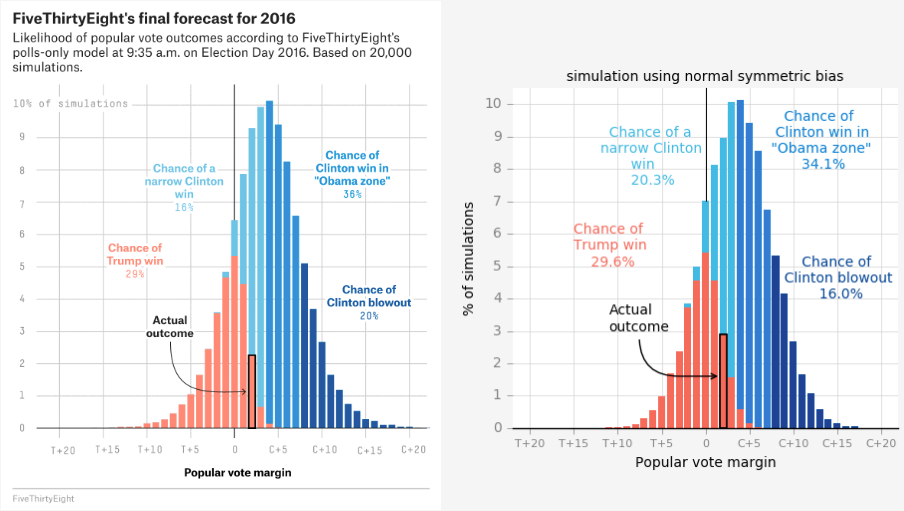

In [6]:
#538 fig at left, simple python simulation at right
from IPython.display import Image
Image(filename='Ex4.2.png')

To calculate the popular vote, you need to multiply the percentage of the vote from your random draw for each state by the total number of votes in that state, and then sum that over all states to get the national popular vote for each simulation.

The `vote_total` field is included in the results2016 data above, e.g.,

In [7]:
results2016['New York']['vote_total']

7721453

The exercise here is to produce a graph like the one at right above, and see how closely it resembles the one on the left. This can be considered a one-parameter fit to the 538 simulation, where the one parameter is the sigma in the random overall bias norm.rvs(0,sigma) for each trial. The similarity suggests that the simple model may somehow capture some significant fraction of whatever it is that 538 used to model electoral volatility.

<hr>
**Note added:**

The colors above were supposed to be self-explanatory in the original 538 plot:

   1. "clinton blowout" (dark blue) is clinton winning electoral college, and winning the popular vote in the C+8 or more bins;

   2. "obama zone" (medium blue) is clinton is clinton winning electoral college, and winning popular vote in the C+4 through C+7 bins;

   3. "narrow win" (lighter blue) is clinton winning electoral college, and clinton winning popular vote in the C+3 or below bins;

   4. "trump win" (red) is trump winning the electoral college, with any popular vote margin

Since the bins are centered on integers, they actually correspond to the range +/- .5 about that value. For example, the C+5 bin includes all simulations for which Clinton's popular vote margin is between 4.5 and 5.5. That means the "Obama zone" above includes popular vote margin anywhere from 3.5 to 7.5 percentage points, in the C+4 through C+7 bins.

`plt.bar()` accepts a list of colors so it's simple to plot multiple colors using, e.g.,

    plt.bar(range(1,7),range(1,7),color='bggrrr')

Whether or not you try to reproduce the full color scheme, you should have at least two colors (red and blue), *AND* you should calculate the percentages in groups 1 through 4 (those are the numbers in the text annotations, though up to you whether to include as annotations in the plot, or just print out separately).

In addition, note that the vertical represents the total percentage of simulations with any given popular vote margin, so for example in the above figure at right roughly 7% of the simulations had a margin of 0, about 3/4 of that bin Trump electoral college wins.  (The percentages with Trump and Clinton wins are stacked one on top of the other, with roughly 5.5% of the simulations in that bin having a Trump win, and roughly 1.5% in that bin with Clinton win. One way to plot this would to use the bottom=... parameter to lift the blue parts of the bars to start at the tops of the red; or you could first plot the total in blue and superimpose the red afterwards.)

## 3)  Presidential Election Simulation III

This problem repeats parts of **1.** and **2.** above for the purposes of modeling how one might project the 2020 election.

**A)** In **1A** above you drew from each of the specified 51 distributions, and based on whether that draw for the state was less than .5 ('Clinton') or greater than .5 ('Trump'), assigned the electoral votes to the winning candidate, tallied them up for all of the states and the candidate with 270 or more was declared the winner for that set of trials; then repeated 10000 times to determine the overall probability of winning.

The problem here will be to try to use the data to instead model the 2020 election in a *very* rough way.  The
[current poll](https://projects.fivethirtyeight.com/trump-approval-ratings/voters/) of likely or registered voters shows Trump with a 43.9% approval rating. (This was early the morning of 20 Mar, it might soon change ...). From the 2016 data you can determine that Trump won 46% of the popular vote.<br>
So a naive extrapolation would start by using the *actual* numbers from the 2016 data to determine the means state by state (e.g. for the above data for New York that would be 36.5/(36.5+59) = .382, for the two candidate comparison). But then discount it by a factor of 43.9/46, to represent the loss of support since then (so for New York that would give .365). Next we'll model the uncertainty of our extrapolation still more than a half year in advance by taking the standard deviation from the poll data and double it for each state (so for New York that would give `2*.02714 = .053`).

Using this method for the fifty states plus DC, perform the draws from the normal distribution, record who wins each state, add up the electoral votes and determine the likely winner of the electoral college. Then repeat 10000 times.
In your simulations, you should also keep track of the number of electoral votes won in each trial to calculate the expected number of electoral votes won by each candidate (by taking the average over the 10000 simulations).

Part of the objective here is just to assay whether even with loss of support since 2016, the non-representative nature of the electoral college will still give some chance of winning under the above assumptions.

<br>
**B)** 
You should have found a very small chance of winning in part **A**, but that would also have been the case if drawing directly from the 2016 final poll data, without taking volatility into account. In **1B** above, it was suggested to use `norm.rvs(0,.016)` to simulate the fivethirtyeight projection on 8 Nov 2016, but now more than a half year in advance it's sensible to use a bigger standard deviation, e.g., `norm.rvs(0,.05)`, due to the additional uncertainty (and comparable to the typical assumed polling standard deviation assumed above).  Redo the simulation of part **A** with the randomly chosen bias added for each of the 10000 simulations.

**C)** For the simple model in **B)** above (i.e., draws from 51 normal distributions, and with the above random bias `norm.rvs(0,sigma)`) for sigma=.05, produce a graph showing the full distribution as in problem **2.**. 

The graph at right below is an example of such a graph produced by the simple model (and again gimmicked in matplotlib to mimic the 538 format), based on 20,000 simulations. Yours should as well show significantly more spread than in problem **2.** due to the increased uncertainties.

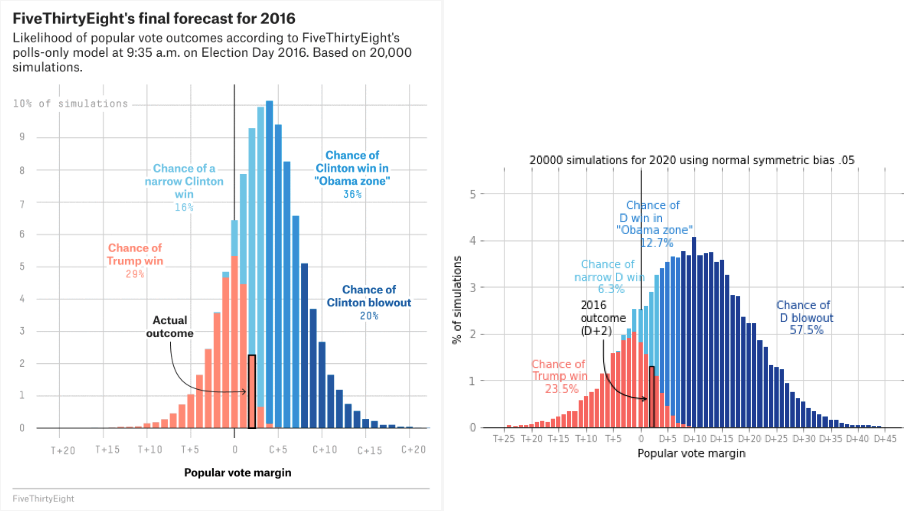

In [8]:
#538 fig at left, simple python simulation at right
from IPython.display import Image
Image(filename='Ex4.3C.png')

## 4) COVID-19 / SARS-CoV-2 "Simulation"

This problem is a simple extension of the article [meaningless counts](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) (Silver, 4 Apr 2020) discussed at the beginning of [lec9.pdf](https://www.cs.cornell.edu/~ginsparg/6010/spr20/lec9_sty.pdf). The first slide shows the basic assumptions made in the article regarding the spectrum of cases, confounding cases, false negative and false positive rates of the test, and rationing of the tests. (The article gives many more details, please read.) The subsequent slides show the results for four scenarios, which I've resimulated here (with some minor numerical differences not evident from plots, but otherwise strong qualitative agreement):

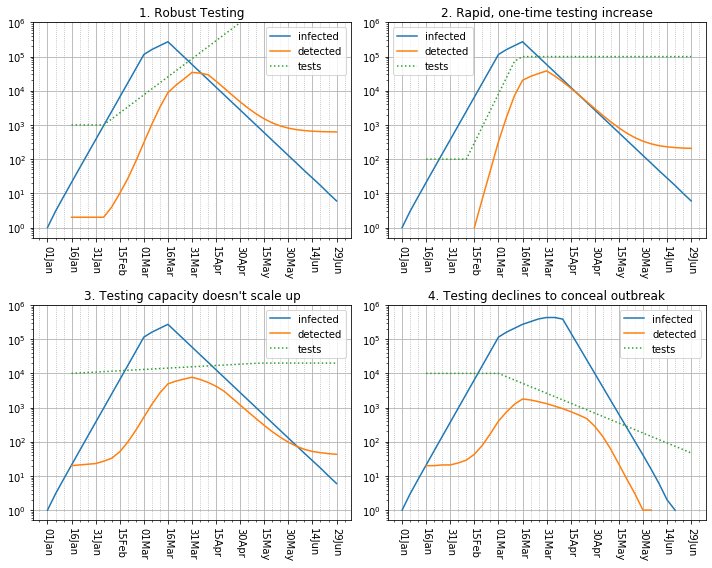

Recall that exponential growth on a semi-log plot (y-axis here) appears as a straight line (hence the piecewise linear behavior of the number of infected).<br>
Note that I've also added to the above (green dotted line) the number of available tests in the scenarios, since that was a crucial changed assumption in the four scenarios:

**Scenario 1:**
<blockquote>Covidia starts out with the capacity to do 1,000 tests per generation, and beginning in early February, it improves testing volume by 50 percent per generation until all testing demand is satisfied.</blockquote>

**Scenario 2:**
<blockquote>Covidia starts out with the capacity to conduct only 100 tests per generation, but then goes on a crash program in February and rapidly increases that number at a rate of 200 percent per generation until it maxes out at 100,000 tests about a month later. This is similar to the situation in the United States, where testing started out slow, improved rapidly and has now stalled out again.</blockquote>

**Scenario 3:**
<blockquote>Covidia starts out with up to 10,000 tests available per generation. However, it scales up tests very slowly (by just 3 percent per generation) before eventually capping out at 20,000 tests per generation.</blockquote>

**Scenario 4:**
<blockquote>Covidia starts out with the capacity to conduct 10,000 tests per generation. However, as the case count begins to accelerate, the government panics that the outbreak will make it look bad, so it subtly starts scaling down testing capacity by 20 percent per generation in early March. Meanwhile, being in denial about the scale of the problem, it doesn’t implement a full lockdown until April 10, or more than three weeks later than under the other scenarios.</blockquote>

In short, the simulations start with a total population of 10M, 1 person infected on 1 Jan, and then calculate the number of people infected at the beginning of each succesive five day period by multiplying the previous number of infectees by R (and rounding to the nearest integer), and so on.  The number of positive tests recorded 15 days later (5+ days for symptoms to show, and up to 10 days for test results to be returned) is then calculated based on test availability and the spectrum of symptoms, under the assumptions for rationed testing.

In creating the above plots, I used the values from the tables (which differed in some  minor ways from his text descriptions):

In [6]:
R0 = [2.6]*12 + [1.4,1.3,1.3] + [.6]*21
R1 = R0
R2 = R0
R3 = [2.6]*12 + [1.4,1.3,1.3,1.2,1.2,1.1,1.0,.9] + [.4]*16

tests0 = [1000]*4 + [round(1000*1.5**i) for i in range(30)]
tests1 = [100]*5 + [100*3**i for i in range(7)] + [100000]*22
tests2 = [round(10000*1.03**i) for i in range(24)] + [20000]*10
tests3 = [10000]*9 + [round(10000*.8**i) for i in range(25)]

This problem has three parts, all based on scenario 2, the most "similar to the situation in the United States":

### A.
i) Reproduce the data and figure for scenario 2. (You're also welcome to do the other three, since they're quite simple once you have the code for any one, but that's not required here.)<br>
ii) What is the largest "effective" value of R in your test data (ratio between numbers of positive test results in successive time periods).<br>
iii) How many actual newly infected are there on 1 Mar, when the first social constraints are imposed, how many positive tests are registered at that time, and what is the ratio of those two numbers? What is the ratio between the cumulative numbers of postive tests and actual infected up to that date?<br>
iv) What are those same two numbers and two ratios on 16 Mar, when more stringent constraints are imposed?<br>
v) For the six month (Jan-Jun) timeframe, what is the ratio of total positive test results to total number infected?

### B.
In class there was a suggestion to consider the effect of a momentary increase in R, either due to a primary vote (e.g., [Wisconsin](https://slate.com/news-and-politics/2020/04/never-forget-wisconsin.html) 7 Apr), or states that decided to permit religious gatherings for Easter (e.g., [Kansas](https://slate.com/news-and-politics/2020/04/kansas-republicans-governor-coronavirus-order-large-religious-gatherings-easter.html) 12 Apr).

You can simulate this with a one time jump of R from .6 up to 1.5 (or you can make an estimate based on some more principled methodology) during the relevant timeframes. Draw a graph as in part A<br>
i) How much longer would it take to get the actual number of new infections to below 10?<br>
ii) How many more infections would this result in (cumulative through end Jun)?<br>
Assuming a 1% IFR (infection fatality rate, although estimates on this 
[vary widely](https://www.cebm.net/covid-19/global-covid-19-case-fatality-rates/)), how many more people will die in the six month timeframe?

### C. 
There are now "[deliberations](https://www.nytimes.com/2020/04/10/us/politics/coronavirus-trump-economy.html)" regarding whether the current stay-at-home guidelines should be lifted when they expire on April 30. Suppose in scenario 2 that R instead returns to 1.3 for all of May and Jun. Draw a graph as in part A. How many more people will be infected cumulatively by the end of Jun?